In [63]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
df = pd.read_csv('/content/MSFT.csv')

In [66]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400


In [67]:
df = df[['Date', 'Close']]

In [68]:
df.head()

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090


In [69]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [70]:
df['Date'] = df['Date'].apply(str_to_datetime)

<ipython-input-70-82fc7f804c29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


In [71]:
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9646   2024-06-24
9647   2024-06-25
9648   2024-06-26
9649   2024-06-27
9650   2024-06-28
Name: Date, Length: 9651, dtype: datetime64[ns]

In [72]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9646,2024-06-24,447.670013
9647,2024-06-25,450.950012
9648,2024-06-26,452.160004
9649,2024-06-27,452.850006


In [73]:
df.index = df.pop('Date')

In [74]:
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-06-24,447.670013
2024-06-25,450.950012
2024-06-26,452.160004


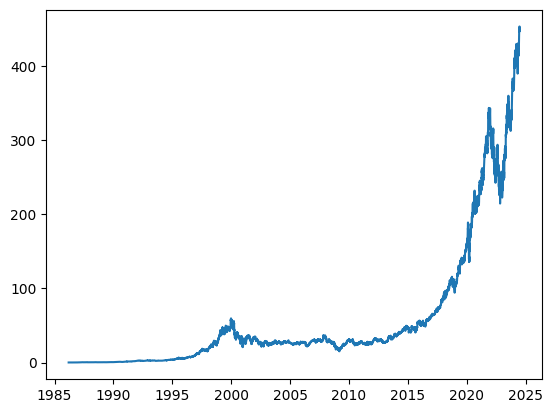

In [75]:
plt.plot(df.index, df['Close'])

In [76]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df


In [77]:
# Start day second time around: '1986-03-18'
windowed_df = df_to_windowed_df(df,
                                '2022-03-18',
                                '2024-06-28',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-03-18,287.149994,294.390015,295.220001,300.429993
1,2022-03-21,294.390015,295.220001,300.429993,299.160004
2,2022-03-22,295.220001,300.429993,299.160004,304.059998
3,2022-03-23,300.429993,299.160004,304.059998,299.489990
4,2022-03-24,299.160004,304.059998,299.489990,304.100006
...,...,...,...,...,...
568,2024-06-24,446.339996,445.700012,449.779999,447.670013
569,2024-06-25,445.700012,449.779999,447.670013,450.950012
570,2024-06-26,449.779999,447.670013,450.950012,452.160004
571,2024-06-27,447.670013,450.950012,452.160004,452.850006


In [78]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:,0]

  middle_matrix = df_as_np[:, 1 : -1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [79]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((573,), (573, 3, 1), (573,))

In [80]:
q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]


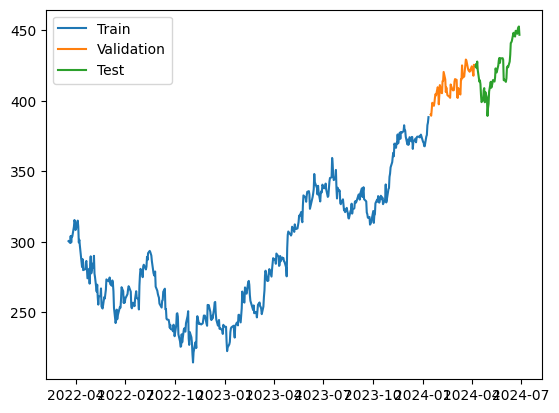

In [81]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)


plt.legend(['Train', 'Validation', 'Test'])

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [83]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

In [84]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15/15 [==============================] - 3s 49ms/step - loss: 86718.5625 - mean_absolute_error: 291.1568 - val_loss: 167627.5781 - val_mean_absolute_error: 409.3125
Epoch 2/100
15/15 [==============================] - 0s 7ms/step - loss: 86017.7734 - mean_absolute_error: 289.9505 - val_loss: 166480.5312 - val_mean_absolute_error: 407.9088
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: 84883.9297 - mean_absolute_error: 287.9852 - val_loss: 164219.1562 - val_mean_absolute_error: 405.1275
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 82784.5234 - mean_absolute_error: 284.3146 - val_loss: 160396.1406 - val_mean_absolute_error: 400.3813
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 79155.4531 - mean_absolute_error: 277.8270 - val_loss: 152709.6562 - val_mean_absolute_error: 390.6641
Epoch 6/100
15/15 [==============================] - 0s 9ms/step - loss: 72204.9609 - mean_absolute_error: 265.0571 - v

15/15 [==============================] - 1s 3ms/step


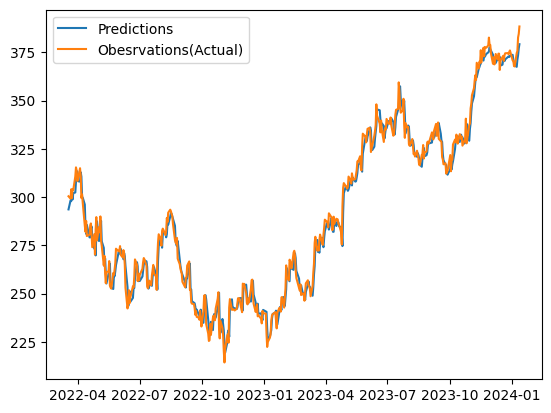

In [85]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Predictions', 'Obesrvations(Actual)'])

2/2 [==============================] - 0s 7ms/step


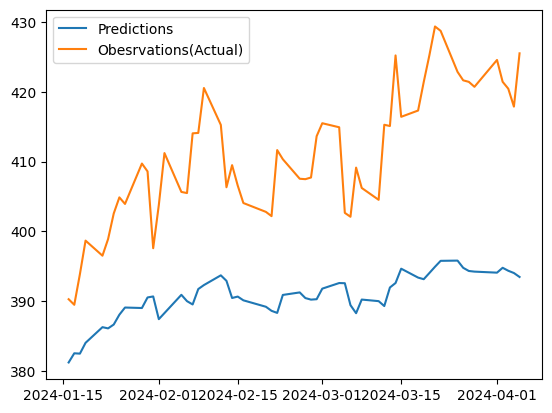

In [86]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Predictions', 'Obesrvations(Actual)'])

2/2 [==============================] - 0s 6ms/step


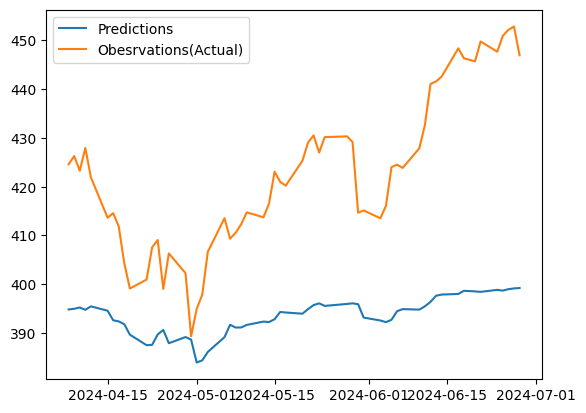

In [87]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Predictions', 'Obesrvations(Actual)'])

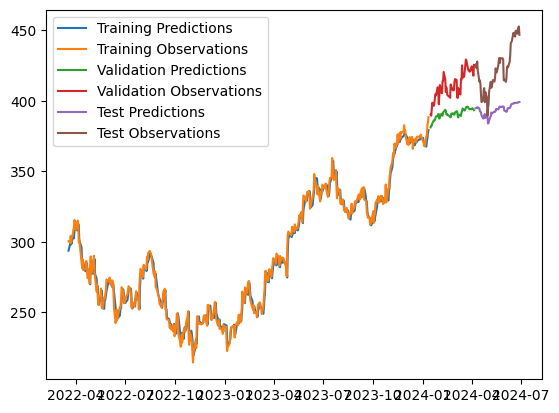

In [88]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations', 'Test Predictions', 'Test Observations'])

In [89]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction


1/1 [==============================] - 0s 25ms/step


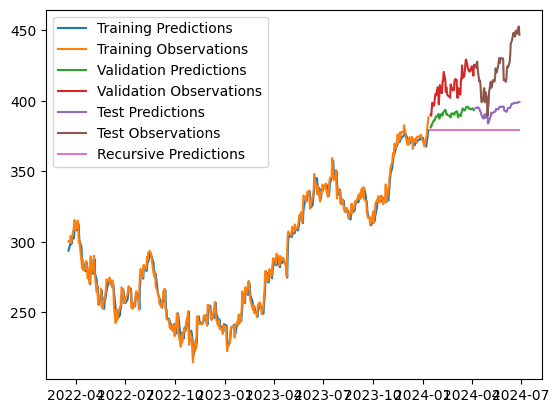

In [90]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations', 'Test Predictions', 'Test Observations', 'Recursive Predictions'])